In [1]:
import pandas as pd
import numpy as np
import os
import json
import pickle
from collections import defaultdict
from datetime import datetime
import openai
import requests
from tenacity import retry, wait_random_exponential, stop_after_attempt
from termcolor import colored
openai.api_key = os.environ.get('OPENAI_API_KEY')

In [2]:
user_test_path = '../fashion_data/processed_data/user_test.json'
user_valid_path = '../fashion_data/processed_data/user_valid.json'

In [3]:
with open(user_test_path, 'rb') as f:
    user_test_dict = json.load(f)
print(len(user_test_dict))

1273


In [4]:
with open(user_valid_path, 'rb') as f:
    user_valid_dict = json.load(f)
print(len(user_valid_dict))

1273


In [5]:
print(user_valid_dict['0'])
print(user_test_dict['0'])

[2, 3, 4, 5, 6]
[3, 4, 5, 6, 7]


In [6]:
item_information_path = '../fashion_data/processed_data/processed_item_information.json'
with open(item_information_path, 'r') as f:
    item_information_dict = json.load(f)
print(len(item_information_dict))

6089


In [7]:
ratings_path = '../fashion_data/processed_data/ratings.csv'
ratings_df = pd.read_csv(ratings_path)
ratings_df.head()

,item,user,rating,timestamp
0,0,0,4.0,1452816000
1,1,0,4.0,1453766400
2,2,0,3.0,1453766400
3,3,0,4.0,1453766400
4,4,0,4.0,1453766400


### Creating zeroshot data

In [8]:
def get_item_description(item_information):
    item_details = ""
    if 'title' in item_information:
        item_details += item_information['title']
    if 'brand' in item_information:
        item_details += f" Brand: {item_information['brand']}"
    if 'price' in item_information:
        item_details += f" Price: {item_information['price']}"
    if 'description' in item_information:
        item_details += f" Description: {item_information['description']}"
    return item_details

In [44]:
### Test Data
zeroshot_dict = dict()
check_missed_items = []
for user, item_list in user_test_dict.items():
    # print(user, item_list)
    user_rating_dict = ratings_df[ratings_df['user'] == int(user)]
    # print(user_rating_dict)
    prompt = "You are an expert fashion product recommender. You are provided with a user's list of recent products and their descriptions that the user purchases and whether the user liked it or disliked it. Please go through the list in order -\n"
    for item in item_list[:-1]:
        user_item_rating = user_rating_dict[user_rating_dict['item'] == item]['rating'].values[0]
        if user_item_rating > 3:
            ### Liked
            prompt += f"Liked {get_item_description(item_information_dict[str(item)])}\n"
        else:
            prompt += f"Disliked {get_item_description(item_information_dict[str(item)])}\n"
    target_item = item_list[-1]
    target_item_details = get_item_description(item_information_dict[str(target_item)])
    prompt += f"""As an expert fashion product recommender, do the following steps -
    1. Analyze the provided list of products purchased by the user in order and summarize the user behavior by identifying the characteristics he liked and disliked about the products in at most 100 words.
    2. Explain with reasoning why the user will like or dislike the target product - {target_item_details} in atmost 100 words.
    3. Finally, from the reasoning, predict whether the user will like the target product or not in the format - Prediction: Yes or No"""
    zeroshot_dict[user] = prompt
    # break

In [9]:
### Valid Data
zeroshot_dict = dict()
check_missed_items = []
for user, item_list in user_valid_dict.items():
    # print(user, item_list)
    user_rating_dict = ratings_df[ratings_df['user'] == int(user)]
    # print(user_rating_dict)
    prompt = "You are an expert fashion product recommender. You are provided with a user's list of recent products and their descriptions that the user purchases and whether the user liked it or disliked it. Please go through the list in order -\n"
    for item in item_list[:-1]:
        user_item_rating = user_rating_dict[user_rating_dict['item'] == item]['rating'].values[0]
        if user_item_rating > 3:
            ### Liked
            prompt += f"Liked {get_item_description(item_information_dict[str(item)])}\n"
        else:
            prompt += f"Disliked {get_item_description(item_information_dict[str(item)])}\n"
    target_item = item_list[-1]
    target_item_details = get_item_description(item_information_dict[str(target_item)])
    prompt += f"""As an expert fashion product recommender, do the following steps -
    1. Analyze the provided list of products purchased by the user in order and summarize the user behavior by identifying the characteristics he liked and disliked about the products in at most 100 words.
    2. Explain with reasoning why the user will like or dislike the target product - {target_item_details} in atmost 100 words.
    3. Finally, from the reasoning, predict whether the user will like the target product or not in the format - Prediction: Yes or No"""
    zeroshot_dict[user] = prompt
    # break

In [10]:
print(len(zeroshot_dict))

1273


In [11]:
zeroshot_dict['34']

"You are an expert fashion product recommender. You are provided with a user's list of recent products and their descriptions that the user purchases and whether the user liked it or disliked it. Please go through the list in order -\nLiked [Promotion]BABAN 32mm Watch Repair Tool Blue Metal Adjuster Watch Band Bracelet Strap Link Pin Remover Brand: BABAN Description: \n\nThe product is a watch band adjustment tool. It is simple to use and good for the price, but may be a bit flimsy. It successfully removes links, but the provided pin is weak.\nLiked Shoes Insoles From SHINAP: Comfort Shoes Inserts, Cut to Size, Lightweight & Breathable, Moisture Wicking Shoe Inserts. Perfect for All Shoes & All Sports, Athletics, Work, Running, Hiking! Brand: ShiNap Description: \n\nProduct: Knee and Foot Pain Relief Inserts\n\nStrengths: \n1. Works as advertised\n2. Eased pain on knees and feet\n3. Comfortable\n4. Can fit to any shoes\n\nWeaknesses: None mentioned in the\nLiked Ysiop Mens Polyester Sk

In [12]:
total_len = 0
for user, prompt in zeroshot_dict.items():
    total_len += len(prompt.strip().split(' '))
print(total_len/len(zeroshot_dict))

1306.6378633150039


In [13]:
users_very_long = []
for user, prompt in zeroshot_dict.items():
    if len(prompt.strip().split(' ')) > 450:
        users_very_long.append(user)

In [14]:
print(len(users_very_long), users_very_long)

340 ['2', '3', '4', '5', '12', '15', '19', '22', '24', '26', '27', '29', '33', '35', '41', '42', '43', '44', '51', '62', '70', '72', '73', '77', '79', '80', '86', '98', '100', '101', '105', '112', '120', '122', '133', '137', '139', '140', '142', '144', '147', '152', '154', '164', '166', '170', '177', '184', '185', '186', '187', '188', '196', '197', '202', '203', '204', '205', '210', '212', '214', '215', '223', '228', '229', '236', '243', '245', '251', '254', '257', '258', '266', '272', '275', '283', '285', '287', '288', '292', '303', '307', '318', '320', '323', '324', '333', '336', '337', '343', '345', '348', '352', '358', '366', '370', '396', '400', '401', '405', '410', '411', '415', '418', '427', '431', '435', '447', '454', '465', '469', '470', '472', '473', '484', '485', '491', '492', '495', '496', '504', '505', '506', '507', '510', '511', '514', '515', '516', '517', '526', '527', '529', '531', '538', '544', '549', '553', '560', '561', '564', '565', '566', '567', '572', '573', '574'

You are an expert fashion product recommender. You are provided with a user's list of recent products and their descriptions that the user purchases and whether the user liked it or disliked it. Please go through the list in order -
Liked var aPageStart = (new Date()).getTime();
var ue_t0=ue_t0||+new Date();

window.ue_ihb = (window.ue_ihb || window.ueinit || 0) + 1;
if (window.ue_ihb === 1) {

var ue_csm = window,
    ue_hob = +new Date();
(function(d){var e=d.ue=d.ue||{},f=Date.now||function(){return+new Date};e.d=function(b){return f()-(b?0:d.ue_t0)};e.stub=function(b,a){if(!b[a]){var c=[];b[a]=function(){c.push([c.slice.call(arguments),e.d(),d.ue_id])};b[a].replay=function(b){for(var a;a=c.shift();)b(a[0],a[1],a[2])};b[a].isStub=1}};e.exec=function(b,a){return function(){if(1==window.ueinit)try{return b.apply(this,arguments)}catch(c){ueLogError(c,{attribution:a||"undefined",logLevel:"WARN"})}}}})(ue_csm);


    var ue_err_chan = 'jserr-rw';
(function(d,e){function h(f,b){if(!(a.ec>
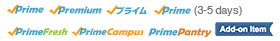

In [15]:
print(zeroshot_dict['1268'])

In [16]:
for key in users_very_long:
    zeroshot_dict.pop(key, None)
print(len(zeroshot_dict))

933


In [17]:
zeroshot_test_path = './ctr_zeroshot_dataset/zeroshot_valid.json'
with open(zeroshot_test_path, 'w+') as f:
    json.dump(zeroshot_dict, f)

In [18]:
ratings_df[ratings_df['user'] == int('0')]

,item,user,rating,timestamp
0,0,0,4.0,1452816000
1,1,0,4.0,1453766400
2,2,0,3.0,1453766400
3,3,0,4.0,1453766400
4,4,0,4.0,1453766400
5,5,0,3.0,1453766400
6,6,0,2.0,1453766400
7,7,0,3.0,1500854400


In [19]:
test_prompt = zeroshot_dict['34']
print(test_prompt)
print("-"*100)
response = openai.completions.create(
    # model = "gpt-3.5-turbo-0125",
    model="gpt-3.5-turbo-instruct",
    prompt = test_prompt,
    temperature=0.3,
    max_tokens=256,
    # top_p=0.3,
    # frequency_penalty=0.5,
    # presence_penalty=0.5
)
print(response.choices[0].text)

You are an expert fashion product recommender. You are provided with a user's list of recent products and their descriptions that the user purchases and whether the user liked it or disliked it. Please go through the list in order -
Liked [Promotion]BABAN 32mm Watch Repair Tool Blue Metal Adjuster Watch Band Bracelet Strap Link Pin Remover Brand: BABAN Description: 

The product is a watch band adjustment tool. It is simple to use and good for the price, but may be a bit flimsy. It successfully removes links, but the provided pin is weak.
Liked Shoes Insoles From SHINAP: Comfort Shoes Inserts, Cut to Size, Lightweight & Breathable, Moisture Wicking Shoe Inserts. Perfect for All Shoes & All Sports, Athletics, Work, Running, Hiking! Brand: ShiNap Description: 

Product: Knee and Foot Pain Relief Inserts

Strengths: 
1. Works as advertised
2. Eased pain on knees and feet
3. Comfortable
4. Can fit to any shoes

Weaknesses: None mentioned in the
Liked Ysiop Mens Polyester Skinny Neck ties B